<a href="https://colab.research.google.com/github/rithickjoshua/Wind-Power-Prediction-Using-LSTM/blob/main/P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install windrose

<ipython-input-14-16aadc96ee35>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AssetName         1126 non-null   object 
 1   Date/Time         1126 non-null   object 
 2   ActivePower(KW)   1126 non-null   float64
 3   WindSpeed(m/sec)  1126 non-null   float64
 4   NacelleDirection  1126 non-null   float64
 5   Temperature(c)    1126 non-null   float64
dtypes: float64(4), object(2)
memory usage: 52.9+ KB


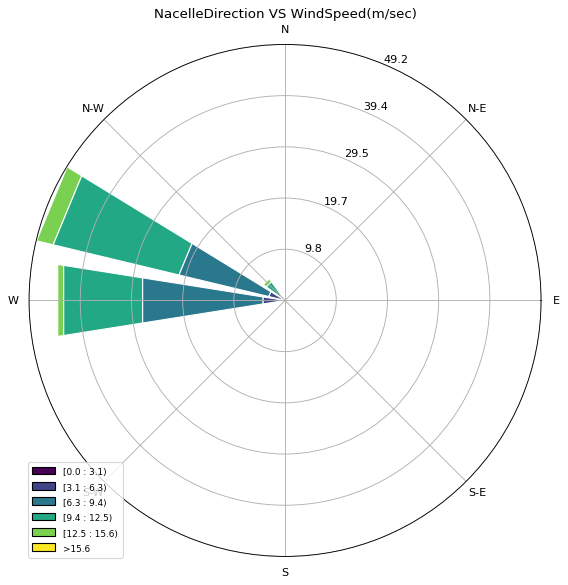

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
<ipython-input-14-16aadc96ee35>:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data.iloc[:, i], shade=True)
<ipython-input-14-16aadc96ee35>:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data.iloc[:, i], shade=True)
<ipython-input-14-16aadc96ee35>:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


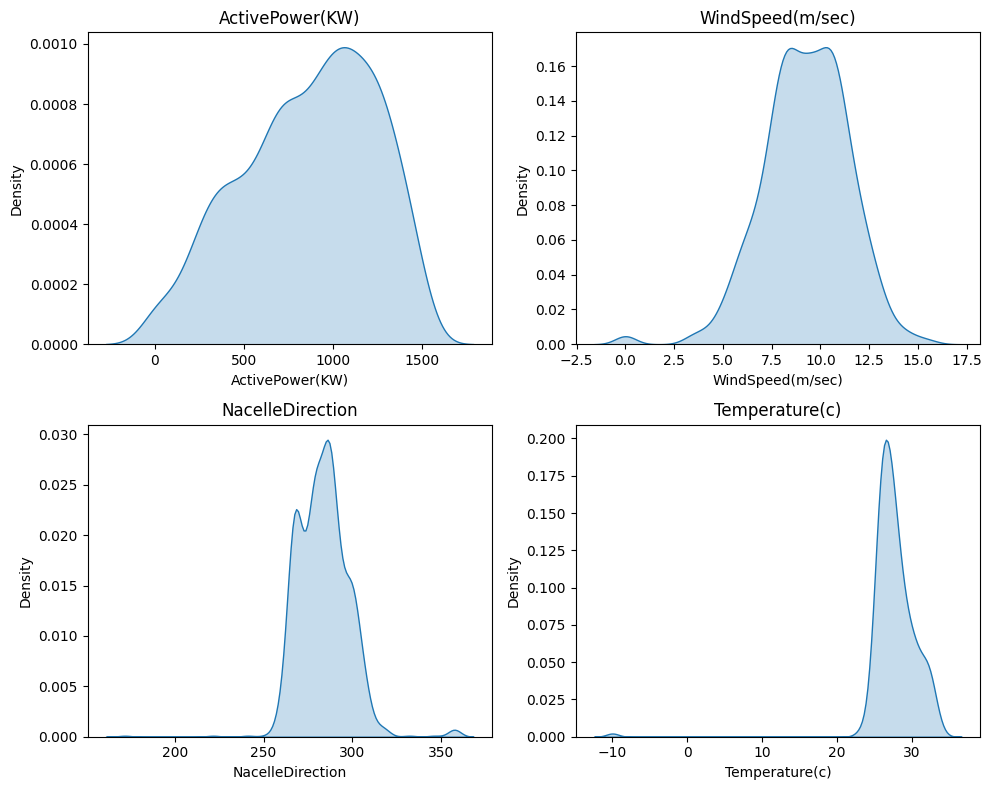

788/788 [==============================] - 2s 3ms/step - loss: 1.4785e-04


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series, concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
import numpy as np

# Reading the dataset
data = pd.read_csv("tatapower.csv")
data.head()

# Data Wrangling
data.info()

data.describe()

data.isnull().sum()

# Assuming you have Windrose installed and similar data structure, let's proceed with visualization
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(data['NacelleDirection'], data['WindSpeed(m/sec)'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("NacelleDirection VS WindSpeed(m/sec)")
plt.show()

# Splitting the date time in year, month, days, hours and minutes
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data['Year'] = data['Date/Time'].dt.year
data['Month'] = data['Date/Time'].dt.month
data['Day'] = data['Date/Time'].dt.day
data['Time_Hours'] = data['Date/Time'].dt.hour
data['Time_Minutes'] = data['Date/Time'].dt.minute
data.head(10)

# KDE Plot
plt.figure(figsize=(10, 8))
for i in range(2, 6):  # Assuming 'ActivePower(KW)', 'WindSpeed(m/sec)', 'NacelleDirection', and 'Temperature(c)' are columns 2 to 5
    plt.subplot(2, 2, i-1)
    sns.kdeplot(data.iloc[:, i], shade=True)
    plt.title(data.columns[i])
plt.tight_layout()
plt.show()

# Drop any null values
data = data.dropna()

# Drop irrelevant features
data = data.drop(['AssetName', 'Date/Time', 'NacelleDirection', 'Temperature(c)'], axis=1)

# LSTM Model Building
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

# frame as supervised learning
lag = 1
supervised = timeseries_to_supervised(data.values, lag)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.7)
train, test = supervised_values[0:train_size], supervised_values[train_size:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
batch_size = 1
nb_epoch = 15
neurons = 10
lstm_model = fit_lstm(train_scaled, batch_size, nb_epoch, neurons)

# walk-forward validation on the test data
predictions = list()
expectations = list()


In [ ]:
for i in range(len(test_scaled) - 1):  # Adjusted range
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(data.values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = data.values[len(train) + i + 1]
    predictions.append(yhat)
    expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat[0], expected[0]))  # Accessing the first element of arrays


1/1 [==============================] - 0s 116ms/step
Hour=1, Predicted=1310.524433, Expected=1414.160000
1/1 [==============================] - 0s 52ms/step
Hour=2, Predicted=1287.658620, Expected=0.000000
1/1 [==============================] - 0s 30ms/step
Hour=3, Predicted=1414.176316, Expected=0.000000
1/1 [==============================] - 0s 31ms/step
Hour=4, Predicted=0.006964, Expected=0.000000
1/1 [==============================] - 0s 33ms/step
Hour=5, Predicted=-0.003658, Expected=0.000000
1/1 [==============================] - 0s 148ms/step
Hour=6, Predicted=0.007963, Expected=0.000000
1/1 [==============================] - 0s 50ms/step
Hour=7, Predicted=0.011946, Expected=0.000000
1/1 [==============================] - 0s 79ms/step
Hour=8, Predicted=0.011816, Expected=0.000000
1/1 [==============================] - 0s 116ms/step
Hour=9, Predicted=0.013012, Expected=0.000000
1/1 [==============================] - 0s 87ms/step
Hour=10, Predicted=0.017767, Expected=0.000000
1/1

Test RMSE: 125.370


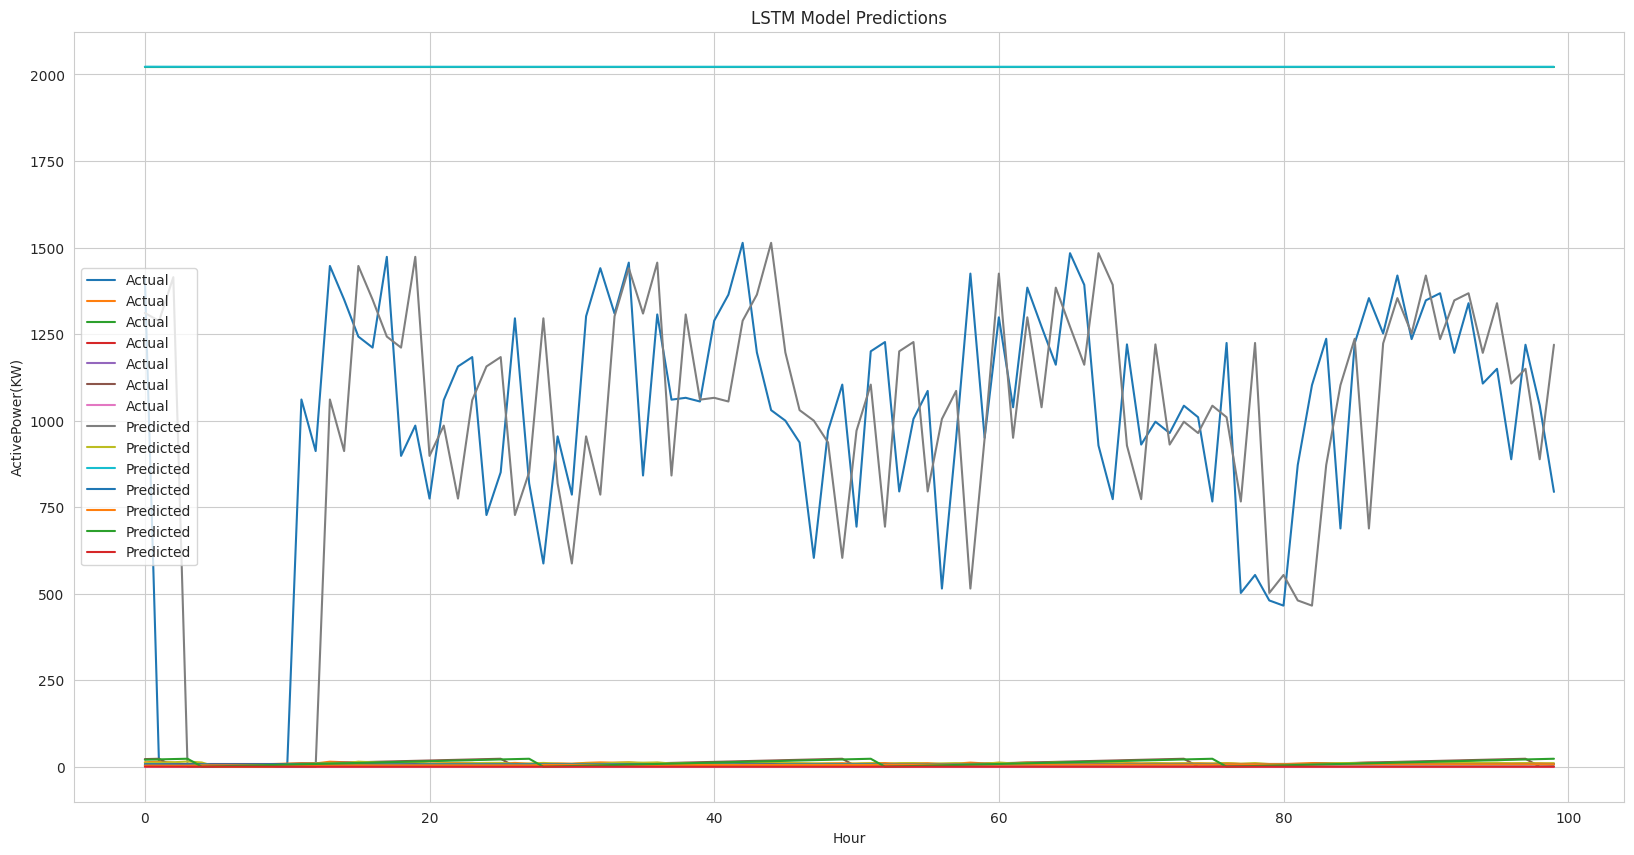

In [ ]:
rmse = sqrt(mean_squared_error(expectations, predictions))
print('Test RMSE: %.3f' % rmse)

# Plotting predictions vs actual values
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
plt.plot(expectations[0:100], label='Actual')
plt.plot(predictions[0:100], label='Predicted')
plt.xlabel('Hour')
plt.ylabel('ActivePower(KW)')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()